In [2]:
from torchvision import datasets, transforms, utils
import torch
import numpy as np
from torch import nn, optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
import pandas as pd
import torchvision.utils as vutils
import os

In [3]:
torch.manual_seed(42)
DATA_PATH = './data'
TRAIN_DATA_PATH = './data/train.csv'
TEST_DATA_PATH = './data/test.csv'
SAMPLE_PATH = './sample/wGAN-GP/'
MODEL_PATH = './model/wGAN-GP/'
GENERATOR_MODEL = 'generator.pth'
DISCRIMINATOR_MODEL = 'discriminator.pth'

# Color channels of the images: 1 for gray-scale.
CHANNELS = 1

BATCH_SIZE = 64
EPOCHS = 50
LEARNING_RATE = 0.0001

Z_DIM = 10
NUM_CLASSES = 10
LABEL_EMBED_SIZE = 5
LAMBDA = 10

IMAGES_DISPLAY_PER_CLASS = 20
LOAD_MODEL = True

In [4]:
transform = transforms.Compose([transforms.Resize((32, 32)), transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
dataset = datasets.FashionMNIST(root = DATA_PATH, train = True, download = True, transform = transform)
train_loader = torch.utils.data.DataLoader(dataset=dataset, batch_size = BATCH_SIZE, shuffle = True, num_workers = 4, drop_last=True)

In [5]:
# Summarize the training data
print('Number of training examples: ', len(train_loader.dataset))
print('Number of training batches: ', len(train_loader))

Number of training examples:  60000
Number of training batches:  937


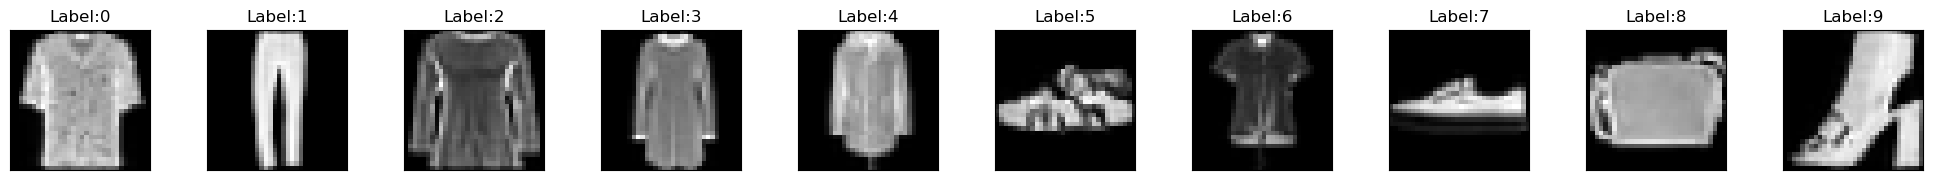

In [6]:
def visualize_data(train_loader):
    """
        Visualize the data
        This function takes in a train_loader and plots 10 images from each class
    """
    # Obtain one batch of training images
    dataiter = iter(train_loader)
    images, labels = next(dataiter)
    images = images.numpy()

    # Plot the images in the batch, along with the corresponding labels
    fig = plt.figure(figsize=(25, 4))
    for idx in np.arange(NUM_CLASSES):
        ax = fig.add_subplot(2, NUM_CLASSES, idx + 1, xticks=[], yticks=[])
        plt.imshow(np.squeeze(images[labels == idx][0]), cmap='gray')
        ax.set_title("Label:" + str(idx))

visualize_data(train_loader)

In [19]:
def generate_image(generator, z, fixed_label, epoch=0, path=SAMPLE_PATH):
    generator.eval()
    image_false = generator(z, fixed_label)
    image_false = (image_false + 1) / 2
    image_false = vutils.make_grid(image_false, nrow=IMAGES_DISPLAY_PER_CLASS, normalize=True)
    vutils.save_image(image_false, os.path.join(path, 'epoch_{}.png'.format(epoch)))

In [20]:
#######################################################################
# conv_block: Convolutional block used in the generator and discriminator
#######################################################################

def conv_block(in_channels, out_channels, kernel_size=4, stride=2, padding=1, batch_norm=True, transpose=False):
    layers = []
    if transpose:
        conv_layer = nn.ConvTranspose2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
        layers.append(conv_layer)
    else:
        conv_layer = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
        layers.append(conv_layer)
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)

In [21]:
class Generator(nn.Module):
    def __init__(self, z_dim=10, n_classes=10, label_embed_size=5, channels=3, conv_dim=64):
        super(Generator, self).__init__()
        self.label_embed = nn.Embedding(n_classes, label_embed_size)
        self.tconv1 = conv_block(z_dim + label_embed_size, conv_dim * 4, padding=0, transpose=True)
        self.tconv2 = conv_block(conv_dim * 4, conv_dim * 2, transpose=True)
        self.tconv3 = conv_block(conv_dim * 2, conv_dim, transpose=True)
        self.tconv4 = conv_block(conv_dim, channels, batch_norm=False, transpose=True)

        for m in self.modules():
            if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight.data, 0.0, 0.02)
            if isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight.data, 1.0)
                nn.init.constant_(m.bias.data, 0)
    
    def forward(self, x, label):
        x = x.reshape([x.shape[0], -1, 1, 1])
        label_embed = self.label_embed(label)
        label_embed = label_embed.reshape([label_embed.shape[0], -1, 1, 1])
        x = torch.cat([x, label_embed], dim=1)
        x = F.relu(self.tconv1(x))
        x = F.relu(self.tconv2(x))
        x = F.relu(self.tconv3(x))
        x = torch.tanh(self.tconv4(x))
        return x
    

class Discriminator(nn.Module):
    def __init__(self, n_classes=10, channels=3, conv_dim=64):
        super(Discriminator, self).__init__()
        self.image_size = 32
        self.label_embed = nn.Embedding(n_classes, self.image_size * self.image_size)
        self.conv1 = conv_block(channels + 1, conv_dim, batch_norm=False)
        self.conv2 = conv_block(conv_dim, conv_dim * 2)
        self.conv3 = conv_block(conv_dim * 2, conv_dim * 4)
        self.conv4 = conv_block(conv_dim * 4, 1, kernel_size=4, padding=0, batch_norm=False, stride=1)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight.data, 0.0, 0.02)
            if isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight.data, 1.0)
                nn.init.constant_(m.bias.data, 0)

    def forward(self, x, label):
        alpha = 0.2
        label_embed = self.label_embed(label)
        label_embed = label_embed.reshape([label_embed.shape[0], 1, self.image_size, self.image_size])
        x = torch.cat([x, label_embed], dim=1)
        x = F.leaky_relu(self.conv1(x), negative_slope=alpha)
        x = F.leaky_relu(self.conv2(x), negative_slope=alpha)
        x = F.leaky_relu(self.conv3(x), negative_slope=alpha)
        # x = torch.sigmoid(self.conv4(x))
        x = self.conv4(x)
        return x.squeeze()

In [22]:
generator = Generator(z_dim=Z_DIM, n_classes=NUM_CLASSES, label_embed_size=LABEL_EMBED_SIZE, channels=CHANNELS)
discriminator = Discriminator(n_classes=NUM_CLASSES, channels=CHANNELS)

In [23]:
# Load the model if LOAD_MODEL is True
if LOAD_MODEL:
    print('Loading the model...')
    generator.load_state_dict(torch.load(os.path.join(MODEL_PATH, 'generator.pth')))
    discriminator.load_state_dict(torch.load(os.path.join(MODEL_PATH, 'discriminator.pth')))  
    print('Model loaded successfully!')                                

Loading the model...
Model loaded successfully!


In [24]:
# Model summary
print('==================== Generator ====================')
print(generator)
print('==================== Discriminator ====================')
print(discriminator)

==================== Generator ====================
Generator(
  (label_embed): Embedding(10, 5)
  (tconv1): Sequential(
    (0): ConvTranspose2d(15, 256, kernel_size=(4, 4), stride=(2, 2), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (tconv2): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (tconv3): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (tconv4): Sequential(
    (0): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
)
==================== Discriminator ====================
Discriminator(
  (label_embed): Embedding(10, 1024)
  (conv1): Sequential(
    (0): Conv2d(2,

In [25]:
# G_optimizer = torch.optim.Adam(generator.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999), weight_decay=2e-5)
# D_optimizer = torch.optim.Adam(discriminator.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999), weight_decay=2e-5)

G_optimizer = torch.optim.RMSprop(generator.parameters(), lr=LEARNING_RATE)
D_optimizer = torch.optim.RMSprop(discriminator.parameters(), lr=LEARNING_RATE)

# Loss function
# criterion = nn.BCELoss()

# Fix images
fixed_z = torch.randn(IMAGES_DISPLAY_PER_CLASS * NUM_CLASSES, Z_DIM)
fixed_label = torch.arange(0, NUM_CLASSES)
fixed_label = torch.repeat_interleave(fixed_label, IMAGES_DISPLAY_PER_CLASS)

# labels for real and fake images
real_label = torch.ones(BATCH_SIZE)
fake_label = torch.zeros(BATCH_SIZE)

# Move to GPU
if torch.cuda.is_available():
    generator = generator.cuda()
    discriminator = discriminator.cuda()
    # criterion = criterion.cuda()
    fixed_z = fixed_z.cuda()
    fixed_label = fixed_label.cuda()
    real_label = real_label.cuda()
    fake_label = fake_label.cuda()
else:
    print('CUDA is not available.')


In [26]:
total_iter = 0
max_iter = len(train_loader)

G_losses = []
D_losses = []

In [27]:
def cal_gradient_penalty(x_real, x_fake, label):
    alpha = torch.rand(BATCH_SIZE, 1, 1, 1)
    alpha = alpha.cuda() if torch.cuda.is_available() else alpha

    x_hat = alpha * x_real + (1 - alpha) * x_fake
    x_hat.requires_grad_(True)

    pred_hat = discriminator(x_hat, label)
    gradients = torch.autograd.grad(outputs=pred_hat, inputs=x_hat, grad_outputs=torch.ones_like(pred_hat), create_graph=True, retain_graph=True)[0]
    gradients = gradients.cuda() if torch.cuda.is_available() else gradients
    gradients = gradients.view(gradients.shape[0], -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

In [28]:
# Training
for epoch in range(EPOCHS):
    generator.train()
    discriminator.train()

    for batch_idx, data in enumerate(train_loader):

        total_iter += 1

        # Load data
        x_real, y_real = data
        z_fake = torch.randn(BATCH_SIZE, Z_DIM)

        if torch.cuda.is_available():
            x_real = x_real.cuda()
            y_real = y_real.cuda()
            z_fake = z_fake.cuda()
        
        # Generate fake images
        x_fake = generator(z_fake, y_real)
        # Train discriminator
        fake_output = discriminator(x_fake.detach(), y_real)
        real_output = discriminator(x_real.detach(), y_real)
        D_loss = -torch.mean(real_output - fake_output)
        gradient_penalty = cal_gradient_penalty(x_real, x_fake.detach(), y_real)
        D_loss += 0.5 * gradient_penalty

        D_optimizer.zero_grad()
        D_loss.backward()
        D_optimizer.step()

        for p in discriminator.parameters():
            p.data.clamp_(-0.01, 0.01)

        # Train generator
        fake_output = discriminator(x_fake, y_real)
        G_loss = -torch.mean(fake_output)
        G_optimizer.zero_grad()
        G_loss.backward()
        G_optimizer.step()

        # Save losses
        G_losses.append(G_loss.item())
        D_losses.append(D_loss.item())

        if batch_idx % 50 == 0:
            print(f'Epoch [{epoch+1}/{EPOCHS}] Batch {batch_idx}/{max_iter} D_loss: {D_loss.item():.4f} G_loss: {G_loss.item():.4f}')

        if (epoch + 1) % 5 == 0:
            torch.save(generator.state_dict(), os.path.join(MODEL_PATH, 'generator2.pth'))
            torch.save(discriminator.state_dict(), os.path.join(MODEL_PATH, 'discriminator2.pth'))
            generate_image(generator, fixed_z, fixed_label, epoch + 1)

    generate_image(generator, fixed_z, fixed_label)

Epoch [1/50] Batch 0/937 D_loss: -0.0037 G_loss: 0.0743
Epoch [1/50] Batch 50/937 D_loss: 0.0332 G_loss: -0.0667
Epoch [1/50] Batch 100/937 D_loss: 0.0745 G_loss: 0.0662
Epoch [1/50] Batch 150/937 D_loss: -0.0309 G_loss: 0.0085
Epoch [1/50] Batch 200/937 D_loss: 0.0303 G_loss: -0.0360
Epoch [1/50] Batch 250/937 D_loss: -0.0229 G_loss: 0.0276
Epoch [1/50] Batch 300/937 D_loss: 0.0358 G_loss: -0.0303
Epoch [1/50] Batch 350/937 D_loss: 0.0078 G_loss: 0.0291
Epoch [1/50] Batch 400/937 D_loss: -0.0110 G_loss: 0.0413
Epoch [1/50] Batch 450/937 D_loss: -0.0289 G_loss: -0.0280
Epoch [1/50] Batch 500/937 D_loss: -0.0020 G_loss: -0.0044
Epoch [1/50] Batch 550/937 D_loss: 0.0317 G_loss: -0.0050
Epoch [1/50] Batch 600/937 D_loss: 0.0273 G_loss: 0.0770
Epoch [1/50] Batch 650/937 D_loss: 0.0089 G_loss: -0.0056
Epoch [1/50] Batch 700/937 D_loss: 0.0178 G_loss: 0.0301
Epoch [1/50] Batch 750/937 D_loss: -0.0015 G_loss: -0.0022
Epoch [1/50] Batch 800/937 D_loss: 0.0031 G_loss: 0.0023
Epoch [1/50] Batch 

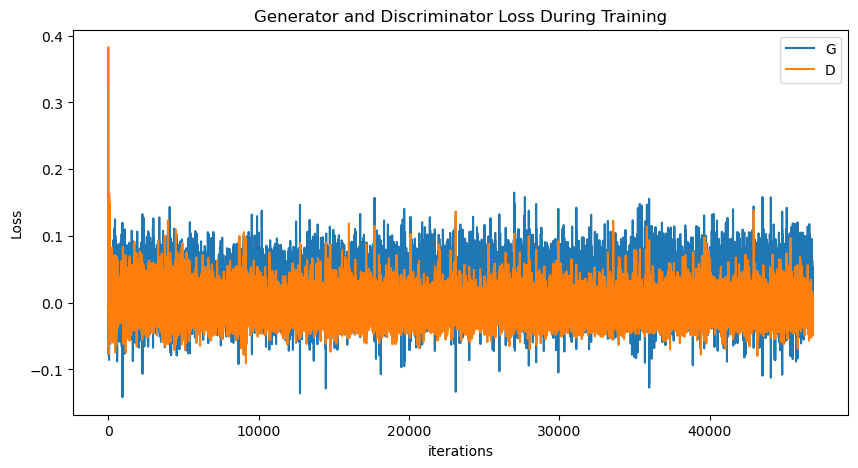

In [29]:
# Plot losses

plt.figure(figsize=(10, 5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses, label="G")
plt.plot(D_losses, label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

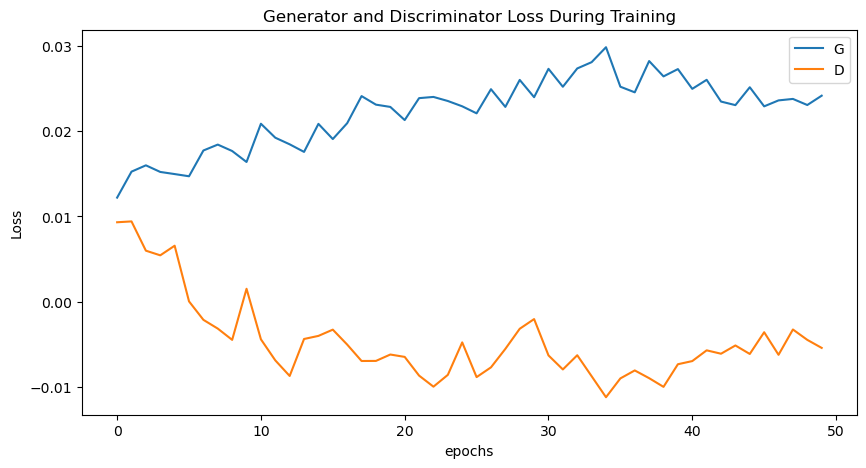

In [30]:
# Plot losses versus epochs
G_loss_per_epoch = []
D_loss_per_epoch = []

for i in range(0, len(G_losses), max_iter):
    G_loss_per_epoch.append(sum(G_losses[i:i+max_iter]) / max_iter)
    D_loss_per_epoch.append(sum(D_losses[i:i+max_iter]) / max_iter)

# remove the last element if it is not a full epoch
if len(G_losses) % max_iter != 0:
    G_loss_per_epoch.pop()
    D_loss_per_epoch.pop()

plt.figure(figsize=(10, 5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_loss_per_epoch, label="G")
plt.plot(D_loss_per_epoch, label="D")
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()